# Autoencoders and GANs

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [3]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


## PCA with a linear Autoencoder

In [4]:
np.random.seed(4)


def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data


X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)


In [6]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))


In [7]:
history = autoencoder.fit(X_train, X_train, epochs=20)


Epoch 1/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 0.

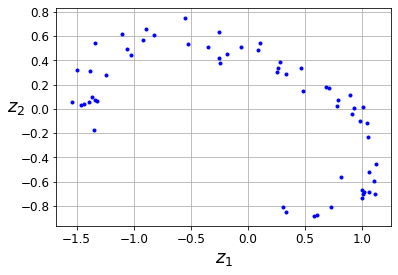

In [8]:
codings = encoder.predict(X_train)

plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()


## Stacked Autoencoders

In [9]:
(X_train_full, y_train_full), (
    X_test,
    y_test,
) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


In [11]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(30, activation="selu"),
    ]
)

stacked_decoder = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation="selu", input_shape=[30]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28]),
    ]
)

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1.5),
    metrics=[rounded_accuracy],
)
history = stacked_ae.fit(
    X_train, X_train, epochs=20, validation_data=(X_valid, X_valid)
)


Epoch 1/20
1719/1719 [==============================] - 28s 16ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3169 - val_rounded_accuracy: 0.8997
Epoch 2/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9200
Epoch 3/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2985 - val_rounded_accuracy: 0.9200
Epoch 4/20
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2937 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 29s 17ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9285
Epoch 6/20
1719/1719 [==============================] - 29s 17ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2916 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [======

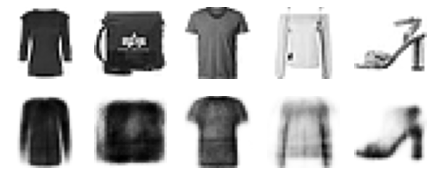

In [15]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


show_reconstructions(stacked_ae)


## Visualizing Fashion MNIST

In [16]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())


/usr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


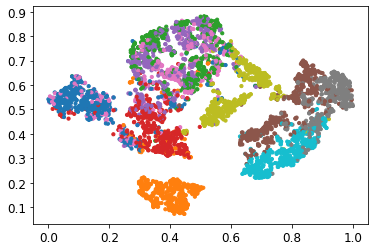

In [17]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

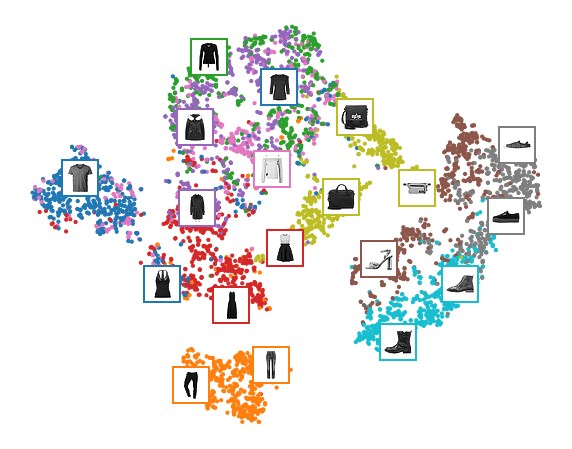

In [18]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1.0, 1.0]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02:  # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position,
            bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2},
        )
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()


## Tying Weights

In [19]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(
            name="bias", shape=[self.dense.input_shape[-1]], initializer="zeros"
        )
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)


In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        dense_1,
        dense_2,
    ]
)

tied_decoder = keras.models.Sequential(
    [
        DenseTranspose(dense_2, activation="selu"),
        DenseTranspose(dense_1, activation="sigmoid"),
        keras.layers.Reshape([28, 28]),
    ]
)

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1.5),
    metrics=[rounded_accuracy],
)

history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))


Epoch 1/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3082 - val_rounded_accuracy: 0.9077
Epoch 2/10
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2952 - val_rounded_accuracy: 0.9285
Epoch 3/10
1719/1719 [==============================] - 40s 24ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3023 - val_rounded_accuracy: 0.9078
Epoch 4/10
1719/1719 [==============================] - 38s 22ms/step - loss: 0.2889 - rounded_accuracy: 0.9301 - val_loss: 0.2880 - val_rounded_accuracy: 0.9333
Epoch 5/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2874 - val_rounded_accuracy: 0.9313
Epoch 6/10
1719/1719 [==============================] - 39s 23ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2861 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [======

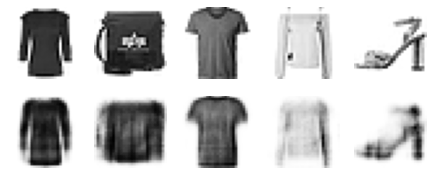

In [21]:
show_reconstructions(tied_ae)
plt.show()


## Using Convolutional Layers Instead of Dense Layers

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential(
    [
        keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
        keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
        keras.layers.MaxPool2D(pool_size=2),
    ]
)
conv_decoder = keras.models.Sequential(
    [
        keras.layers.Conv2DTranspose(
            32,
            kernel_size=3,
            strides=2,
            padding="VALID",
            activation="selu",
            input_shape=[3, 3, 64],
        ),
        keras.layers.Conv2DTranspose(
            16, kernel_size=3, strides=2, padding="SAME", activation="selu"
        ),
        keras.layers.Conv2DTranspose(
            1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"
        ),
        keras.layers.Reshape([28, 28]),
    ]
)
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1.0),
    metrics=[rounded_accuracy],
)
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))


Epoch 1/5
1719/1719 [==============================] - 100s 58ms/step - loss: 0.3019 - rounded_accuracy: 0.9187 - val_loss: 0.2844 - val_rounded_accuracy: 0.9297
Epoch 2/5
1719/1719 [==============================] - 112s 65ms/step - loss: 0.2756 - rounded_accuracy: 0.9414 - val_loss: 0.2729 - val_rounded_accuracy: 0.9456
Epoch 3/5
1719/1719 [==============================] - 109s 64ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2697 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 110s 64ms/step - loss: 0.2682 - rounded_accuracy: 0.9491 - val_loss: 0.2686 - val_rounded_accuracy: 0.9491
Epoch 5/5
1719/1719 [==============================] - 110s 64ms/step - loss: 0.2664 - rounded_accuracy: 0.9510 - val_loss: 0.2672 - val_rounded_accuracy: 0.9506


In [24]:
conv_encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)         

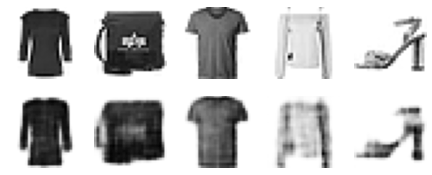

In [25]:
show_reconstructions(conv_ae)
plt.show()


## Stacked Denoising Autoencoder

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.GaussianNoise(0.2),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(30, activation="selu"),
    ]
)

denoising_decoder = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation="selu", input_shape=[30]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28]),
    ]
)

denosing_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denosing_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1.0),
    metrics=[rounded_accuracy],
)

history = denosing_ae.fit(
    X_train, X_train, epochs=10, validation_data=(X_valid, X_valid)
)


Epoch 1/10
1719/1719 [==============================] - 40s 23ms/step - loss: 0.3500 - rounded_accuracy: 0.8773 - val_loss: 0.3166 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3089 - val_rounded_accuracy: 0.9153
Epoch 3/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.3060 - rounded_accuracy: 0.9148 - val_loss: 0.3033 - val_rounded_accuracy: 0.9179
Epoch 4/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3025 - rounded_accuracy: 0.9179 - val_loss: 0.2999 - val_rounded_accuracy: 0.9218
Epoch 5/10
1719/1719 [==============================] - 47s 27ms/step - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2973 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 44s 25ms/step - loss: 0.2974 - rounded_accuracy: 0.9223 - val_loss: 0.2959 - val_rounded_accuracy: 0.9267
Epoch 7/10
1719/1719 [======

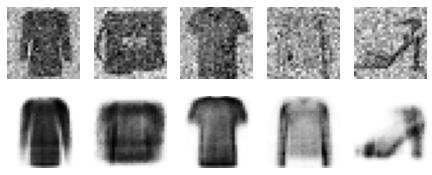

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denosing_ae, noise(X_valid, training=True))
plt.show()


## Sparse Autoencoder

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(30, activation="sigmoid"),
    ]
)

simple_decoder = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation="selu", input_shape=[30]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28]),
    ]
)

simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1.0),
    metrics=[rounded_accuracy],
)
history = simple_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))


Epoch 1/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.4329 - rounded_accuracy: 0.7950 - val_loss: 0.3773 - val_rounded_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 31s 18ms/step - loss: 0.3612 - rounded_accuracy: 0.8668 - val_loss: 0.3514 - val_rounded_accuracy: 0.8797
Epoch 3/10
1719/1719 [==============================] - 32s 18ms/step - loss: 0.3410 - rounded_accuracy: 0.8852 - val_loss: 0.3367 - val_rounded_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 28s 16ms/step - loss: 0.3288 - rounded_accuracy: 0.8954 - val_loss: 0.3263 - val_rounded_accuracy: 0.8991
Epoch 5/10
1719/1719 [==============================] - 31s 18ms/step - loss: 0.3213 - rounded_accuracy: 0.9011 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 6/10
1719/1719 [==============================] - 32s 19ms/step - loss: 0.3176 - rounded_accuracy: 0.9038 - val_loss: 0.3179 - val_rounded_accuracy: 0.9050
Epoch 7/10
1719/1719 [======

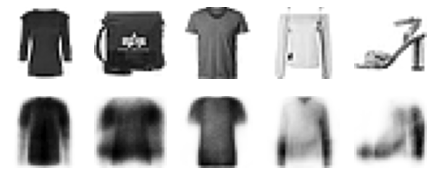

In [31]:
show_reconstructions(simple_ae)
plt.show()

## Generative Adversarial Networks

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
        keras.layers.Dense(150, activation="selu"),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        # Generate image 28 X 28
        keras.layers.Reshape([28, 28]),
    ]
)

discriminator = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(150, activation="selu"),
        keras.layers.Dense(100, activation="selu"),
        # Just generate YES/NO
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

gan = keras.models.Sequential([generator, discriminator])

In [34]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")


In [35]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)


In [36]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


In [40]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))  # not shown in the book
        for X_batch in dataset:
            # Phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # Phase 2 - training the generator with a freezed discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.0]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)  # not shown
        plt.show()


Epoch 1/1


2022-03-26 23:16:22.736556: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-26 23:16:22.844495: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-26 23:16:22.881635: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-26 23:16:22.930213: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-26 23:16:23.077404: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-26 23:16:23.102054: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-26 23:16:23.151215: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-26 23:16:23.263598: W tensorflow/core/data/root_dataset.cc:20

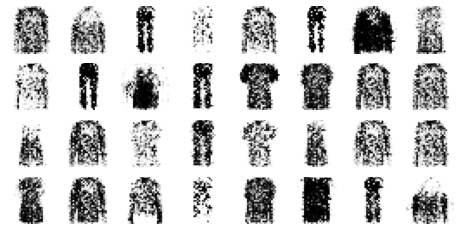

In [41]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)
